In [39]:
import pandas as pd
import numpy as np
import sqlite3
import altair as alt
import scipy.interpolate as interpolate
from scipy.stats import skewnorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [40]:
con = sqlite3.connect("switrs.sqlite")

query = """
    SELECT * FROM collisions WHERE county_location = 'los angeles'
    """

df = pd.read_sql_query(query, con, parse_dates = ["collision_date"])

dfc = df[["case_id", "county_location", "alcohol_involved", "collision_severity", "injured_victims", "collision_date", "collision_time", "party_count"]]

In [4]:
dfi_la, dfi_sd = pd.DataFrame(), pd.DataFrame()

dfi_la["count"] = dfc.query("county_location == 'los angeles'")["injured_victims"].value_counts()
dfi_la["logcount"] = dfi_la["count"].apply(lambda x: np.log(x))
dfi_la["injured_victims"] = dfc.query("county_location == 'los angeles'")["injured_victims"].value_counts().index
dfi_la["county"] = "Los Angeles"

dfi_sd["count"] = dfc.query("county_location == 'san diego'")["injured_victims"].value_counts()
dfi_sd["logcount"] = dfi_sd["count"].apply(lambda x: np.log(x))
dfi_sd["injured_victims"] = dfc.query("county_location == 'san diego'")["injured_victims"].value_counts().index
dfi_sd["county"] = "San Diego"

dfi = pd.concat([dfi_la, dfi_sd])

injuries = alt.Chart(dfi).mark_bar(opacity = 0.75, width = 11).encode(
    x = alt.X("injured_victims:Q"),
    y = alt.Y("count:Q").stack(None).scale(type = "log"),
    color = "county"
).properties(width = 800, height = 300)

(injuries).display()

alt.Chart(...)

In [5]:
# same as above but scaled to total accidents per county

dfi_la, dfi_sd = pd.DataFrame(), pd.DataFrame()

dfi_la["count"] = dfc.query("county_location == 'los angeles'")["injured_victims"].value_counts()
dfi_la["pcount"] = dfi_la["count"] / len(dfc.query("county_location == 'los angeles'"))
dfi_la["logpcount"] = dfi_la["pcount"].apply(lambda x: np.log(x))
dfi_la["injured_victims"] = dfc.query("county_location == 'los angeles'")["injured_victims"].value_counts().index
dfi_la["county"] = "Los Angeles"

dfi_sd["count"] = dfc.query("county_location == 'san diego'")["injured_victims"].value_counts()
dfi_sd["pcount"] = dfi_sd["count"] / len(dfc.query("county_location == 'san diego'"))
dfi_sd["logpcount"] = dfi_sd["pcount"].apply(lambda x: np.log(x))
dfi_sd["injured_victims"] = dfc.query("county_location == 'san diego'")["injured_victims"].value_counts().index
dfi_sd["county"] = "San Diego"

dfi = pd.concat([dfi_la, dfi_sd])

injuries = alt.Chart(dfi).mark_bar(opacity = 0.75, width = 11).encode(
    x = alt.X("injured_victims:Q"),
    y = alt.Y("pcount:Q").stack(None).scale(type = "log"),
    color = "county"
).properties(width = 800, height = 300)

(injuries).display()

alt.Chart(...)

In [6]:
# average injuries per collision for each county

avgila = dfc.query("county_location == 'los angeles'")["injured_victims"].sum() / len(dfc.query("county_location == 'los angeles'"))
avgisd = dfc.query("county_location == 'san diego'")["injured_victims"].sum() / len(dfc.query("county_location == 'san diego'"))

print(avgila, avgisd)

0.5800240188644512 0.7679370271622641


In [7]:
# proportion of accidents with 0 injuries

nipla = len(dfc.query("county_location == 'los angeles' & injured_victims == 0")) / len(dfc.query("county_location == 'los angeles'"))
nipsd = len(dfc.query("county_location == 'san diego' & injured_victims == 0")) / len(dfc.query("county_location == 'san diego'"))

print(nipla, nipsd)

0.6025424932282581 0.45739325909827555


In [8]:
dfy = dfc.copy()

dfy["year"] = dfy["collision_date"].dt.year

dfy_la, dfy_sd = pd.DataFrame(), pd.DataFrame()

dfy_la["count"] = dfy.query("county_location == 'los angeles'").groupby("year")["case_id"].count() / len(dfy.query("county_location == 'los angeles'"))
dfy_la["county"] = "Los Angeles"

dfy_sd["count"] = dfy.query("county_location == 'san diego'").groupby("year")["case_id"].count() / len(dfy.query("county_location == 'san diego'"))
dfy_sd["county"] = "San Diego"

dfyp = pd.concat([dfy_la, dfy_sd]).reset_index().query("year != 2021")

dfyp_plot = alt.Chart(dfyp).mark_bar(opacity = 0.75, width = 36).encode(
    x = alt.X("year:Q"),
    y = alt.Y("count:Q").stack(None),
).properties(width = 800, height = 300)

dfyp_plot.display()

alt.Chart(...)

In [71]:
dfa = dfc.copy()
dfa["year"] = dfa["collision_date"].dt.year
dfa["alcohol_involved"] = dfa["alcohol_involved"].fillna(0)

dfa_alc, dfa_nalc = pd.DataFrame(), pd.DataFrame()

dfa_alc["count"] = dfa.query("alcohol_involved == 1").groupby("year")["case_id"].count() / len(dfa.query("alcohol_involved == 1"))
dfa_alc["alcohol"] = True

dfa_nalc["count"] = dfa.query("alcohol_involved == 0").groupby("year")["case_id"].count() / len(dfa.query("alcohol_involved != 1"))
dfa_nalc["alcohol"] = False

dfap = pd.concat([dfa_nalc, dfa_alc]).reset_index().query("year != 2021")

alt.Chart(dfap).mark_bar(opacity = 0.75, width = 28).encode(
    x = alt.X("year:N"),
    y = alt.Y("count", scale = alt.Scale(domain = [0.03, 0.06]), title = "proportion of group").stack(None),
    color = "alcohol"
).properties(width = 600, height = 200).display()

alt.Chart(...)

In [10]:
dfs = pd.DataFrame(index = ["overall", "LA only", "SD only", "alcohol only", "no alcohol only", "2019 only", "2020 only"], columns = ["number of collisions", "number of injuries", "average injuries per collision"])

queries = ["case_id == case_id", "county_location == 'los angeles'", "county_location == 'san diego'", "alcohol_involved == 1", "alcohol_involved != 1", "year == 2019", "year == 2020"]

dfs.loc["overall", "number of collisions"] = len(dfy.query("case_id == case_id")["case_id"])

dfs.index

for i, row in enumerate(dfs.index):
    dfs.loc[row, "number of collisions"] = len(dfy.query(queries[i])["case_id"])
    dfs.loc[row, "number of injuries"] = dfy.query(queries[i])["injured_victims"].sum().astype(int)
    dfs.loc[row, "average injuries per collision"] = dfs.loc[row, "number of injuries"] / dfs.loc[row, "number of collisions"]

dfs

,number of collisions,number of injuries,average injuries per collision
overall,3387521,2065489,0.609735
LA only,2851925,1654185,0.580024
SD only,535596,411304,0.767937
alcohol only,313129,195775,0.625222
no alcohol only,3074392,1869714,0.608157
2019 only,175364,107761,0.614499
2020 only,131344,79194,0.602951


In [11]:
dfi_alc, dfi_nalc = pd.DataFrame(), pd.DataFrame()

dfi_alc["count"] = dfc.query("alcohol_involved == 1")["injured_victims"].value_counts()
dfi_alc["pcount"] = dfi_alc["count"] / len(dfc.query("alcohol_involved == 1")["case_id"])
dfi_alc["injured_victims"] = dfc.query("alcohol_involved == 1")["injured_victims"].value_counts().index
dfi_alc["alcohol"] = True

dfi_nalc["count"] = dfc.query("alcohol_involved != 1")["injured_victims"].value_counts()
dfi_nalc["pcount"] = dfi_nalc["count"] / len(dfc.query("alcohol_involved != 1")["case_id"])
dfi_nalc["injured_victims"] = dfc.query("alcohol_involved != 1")["injured_victims"].value_counts().index
dfi_nalc["alcohol"] = False

dfia = pd.concat([dfi_nalc, dfi_alc])

injuries_alc = alt.Chart(dfia).mark_bar(opacity = 0.75, width = 11).encode(
    x = alt.X("injured_victims:Q"),
    y = alt.Y("count:Q").stack(None).scale(type = "log"),
    color = "alcohol"
).properties(width = 800, height = 300)

(injuries_alc).display()

pinjuries_alc = alt.Chart(dfia).mark_bar(opacity = 0.75, width = 11).encode(
    x = alt.X("injured_victims:Q"),
    y = alt.Y("pcount:Q").stack(None).scale(type = "log"),
    color = "alcohol"
).properties(width = 800, height = 300)

(pinjuries_alc).display()

alt.Chart(...)

alt.Chart(...)

In [10]:
all_predictors = pd.DataFrame(df.columns.values.reshape(15, 5))


all_predictors

,0,1,2,3,4
0,case_id,jurisdiction,officer_id,reporting_district,chp_shift
1,population,county_city_location,county_location,special_condition,beat_type
2,chp_beat_type,city_division_lapd,chp_beat_class,beat_number,primary_road
3,secondary_road,distance,direction,intersection,weather_1
4,weather_2,state_highway_indicator,caltrans_county,caltrans_district,state_route
5,route_suffix,postmile_prefix,postmile,location_type,ramp_intersection
6,side_of_highway,tow_away,collision_severity,killed_victims,injured_victims
7,party_count,primary_collision_factor,pcf_violation_code,pcf_violation_category,pcf_violation
8,pcf_violation_subsection,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action
9,road_surface,road_condition_1,road_condition_2,lighting,control_device


In [13]:
dfsev = df[["case_id", "county_location", "alcohol_involved", "collision_severity", "injured_victims", "collision_date", "collision_time", "party_count"]]

dfsev["inj_rat"] = dfsev["injured_victims"] / dfsev["party_count"]

C:\Users\seamu\AppData\Local\Temp\ipykernel_3436\685112491.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsev["inj_rat"] = dfsev["injured_victims"] / dfsev["party_count"]


In [14]:
drop_predictors = pd.Series(["collision_severity", "killed_victims", "injured_victims", "severe_injury_count", "other_visible_injury_count", "complaint_of_pain_injury_count", "pedestrian_killed_count", "pedestrian_injured_count", "bicyclist_killed_count", "bicyclist_injured_count", "motorcyclist_killed_count", "motorcyclist_injured_count"])

pd.DataFrame(drop_predictors.values.reshape(3, 4))

,0,1,2,3
0,collision_severity,killed_victims,injured_victims,severe_injury_count
1,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count
2,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count


In [ ]:
con = sqlite3.connect("switrs.sqlite")

query = """
    SELECT * FROM collisions WHERE county_location = 'los angeles'
    """

dfl = pd.read_sql_query(query, con, parse_dates = ["collision_date"])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

y = dfl["collision_severity"]
X = dfl.drop(drop_predictors, axis = 1)

X

,case_id,jurisdiction,officer_id,reporting_district,chp_shift,population,county_city_location,county_location,special_condition,beat_type,...,alcohol_involved,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,primary_ramp,secondary_ramp,latitude,longitude,collision_date,collision_time,process_date
0,0081715,1941,11342,212,not chp,>250000,1941,los angeles,0,not chp,...,NaN,None,None,None,None,NaN,NaN,2020-03-14,07:45:00,2020-06-22
1,3899442,9530,19005,None,0600 thru 1359,>250000,1942,los angeles,0,chp state highway,...,NaN,passenger car,"passenger car, station",None,None,33.86465,-118.28533,2009-02-09,10:20:00,2010-01-14
2,3899445,9530,19284,None,1400 thru 2159,>250000,1942,los angeles,0,chp state highway,...,NaN,passenger car,"passenger car, station",None,None,33.79120,-118.28230,2009-02-18,15:50:00,2010-01-13
3,3899446,9530,19289,None,1400 thru 2159,25000 to 50000,1939,los angeles,0,chp state highway,...,NaN,passenger car,"passenger car, station",None,None,33.88450,-118.35260,2009-02-11,17:35:00,2010-01-11
4,3899449,9530,19374,None,1400 thru 2159,>250000,1941,los angeles,0,chp state highway,...,NaN,passenger car,"passenger car, station",None,None,33.83197,-118.20906,2009-02-13,21:20:00,2009-12-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2851920,7148381,1900,552714,1088,not chp,10000 to 25000,1995,los angeles,0,not chp,...,NaN,passenger car,"passenger car, station",None,None,NaN,NaN,2015-12-16,15:30:00,2016-02-18
2851921,7154520,1942,40643,1177,not chp,>250000,1942,los angeles,0,not chp,...,NaN,None,unknown hit and run vehicle involvement,None,None,NaN,NaN,2015-12-23,18:30:00,2016-01-12
2851922,7205180,9535,021148,None,2200 thru 0559,unincorporated,1900,los angeles,0,chp state highway,...,NaN,None,None,TO,None,34.03334,-118.18097,2015-12-28,04:04:00,2016-03-15
2851923,8005848,1900,600527,1122,not chp,100000 to 250000,1992,los angeles,0,not chp,...,NaN,None,None,None,None,NaN,NaN,2016-03-09,None,2016-03-24


In [ ]:
X["alcohol_involved"] = X["alcohol_involved"].fillna(0)


dfdt = pd.DataFrame()
dfdt["predictor"] = X.dtypes.index
dfdt[""]

# rf = RandomForestClassifier()
# rfc = rf.fit(X, y)

case_id :   object
jurisdiction :   int64
officer_id :   object
reporting_district :   object
chp_shift :   object
population :   object
county_city_location :   object
county_location :   object
special_condition :   object
beat_type :   object
chp_beat_type :   object
city_division_lapd :   object
chp_beat_class :   object
beat_number :   object
primary_road :   object
secondary_road :   object
distance :   float64
direction :   object
intersection :   float64
weather_1 :   object
weather_2 :   object
state_highway_indicator :   float64
caltrans_county :   object
caltrans_district :   float64
state_route :   float64
route_suffix :   object
postmile_prefix :   object
postmile :   float64
location_type :   object
ramp_intersection :   object
side_of_highway :   object
tow_away :   float64
party_count :   float64
primary_collision_factor :   object
pcf_violation_code :   object
pcf_violation_category :   object
pcf_violation :   float64
pcf_violation_subsection :   object
hit_and_run : 

C:\Users\seamu\AppData\Local\Temp\ipykernel_3524\2173266479.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(X.dtypes.index[i], ":  ", X.dtypes[i])
C:\Users\seamu\AppData\Local\Temp\ipykernel_3524\2173266479.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(X.dtypes.index[i], ":  ", X.dtypes[i])
C:\Users\seamu\AppData\Local\Temp\ipykernel_3524\2173266479.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(X.dt

In [ ]:
dfc["alcohol_involved"] = dfc["alcohol_involved"].fillna(0)
dfc["hour"] = pd.to_datetime(dfc["collision_time"]).dt.hour

dftod = pd.DataFrame()

dftod["hour"] = range(0, 24)

dftod["alc"] = dfc.query("alcohol_involved == 1").groupby("hour")["case_id"].count()
dftod["nalc"] = dfc.query("alcohol_involved == 0").groupby("hour")["case_id"].count()
dftod["p"] = dftod["alc"] / dftod["nalc"]

dftod["adj_hour"] = [16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

alt.Chart(dftod).mark_bar(width = 20).encode(
    x = alt.X("adj_hour", title = "Hour of day (adjusted, 0 = 8:00 am)", scale = alt.Scale(domain = [-0.5, 23.5])),
    y = alt.Y("p", title = "Proportion of accidents with alcohol involved")
).properties(width = 600, height = 200).display()

C:\Users\seamu\AppData\Local\Temp\ipykernel_3524\3646291801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc["alcohol_involved"] = dfc["alcohol_involved"].fillna(0)
C:\Users\seamu\AppData\Local\Temp\ipykernel_3524\3646291801.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfc["hour"] = pd.to_datetime(dfc["collision_time"]).dt.hour
C:\Users\seamu\AppData\Local\Temp\ipykernel_3524\3646291801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

alt.Chart(...)

In [83]:
(X.isna().sum() / X.isna().count()).sort_values()

dfnan = pd.DataFrame()

dfnan["predictor"] = (X.isna().sum() / X.isna().count()).sort_values().index
dfnan["p_nan"] = (X.isna().sum() / X.isna().count()).sort_values().values

In [107]:
dfnan[dfnan["p_nan"] > 0.20][:11]

,predictor,p_nan
41,statewide_vehicle_type_at_fault,0.246416
42,direction,0.262887
43,chp_vehicle_type_at_fault,0.293891
44,reporting_district,0.454215
45,pcf_violation_subsection,0.616457
46,postmile,0.734221
47,state_route,0.734221
48,caltrans_district,0.734221
49,longitude,0.755518
50,latitude,0.755518


In [108]:
dfnan[dfnan["p_nan"] > 0.20][11:]

,predictor,p_nan
52,caltrans_county,0.770561
53,side_of_highway,0.770562
54,city_division_lapd,0.788558
55,ramp_intersection,0.905877
56,postmile_prefix,0.907977
57,pcf_violation_code,0.951971
58,primary_ramp,0.982437
59,weather_2,0.982966
60,route_suffix,0.983291
61,secondary_ramp,0.994388


In [5]:
con = sqlite3.connect("switrs.sqlite")

query = """
    SELECT * FROM collisions WHERE county_location = 'los angeles'
    """

df = pd.read_sql_query(query, con, parse_dates = ["collision_date"])
df["year"] = df["collision_date"].dt.year
df["hour"] = pd.to_datetime(df["collision_time"]).dt.hour
df = df.query("year < 2021") # remove incomplete 2021 data
df["alcohol_involved"] = df["alcohol_involved"].fillna(0) # convert NaN to 0 in alcohol use column

dfc = df[["case_id", "county_location", "alcohol_involved", "collision_severity", "injured_victims", "collision_date", "year", "collision_time", "hour", "party_count"]]

C:\Users\seamu\AppData\Local\Temp\ipykernel_26976\3209997596.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["hour"] = pd.to_datetime(df["collision_time"]).dt.hour


In [13]:
# We will attempt to use multiple models to fit this distribution. We will use polynomial splines and B-splines but it appears a skewed-normal may be a possible fit as well.

dfc_tr, dfc_te = train_test_split(dfc, test_size = 0.2, random_state = 13)

# build training data frame
dftod = pd.DataFrame()
dftod["hour"] = range(0, 24)
dftod["alc"] = dfc_tr.query("alcohol_involved == 1").groupby("hour")["case_id"].count()
dftod["nalc"] = dfc_tr.query("alcohol_involved == 0").groupby("hour")["case_id"].count()
dftod["p"] = dftod["alc"] / dftod["nalc"]
dftod["adj_hour"] = [16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# build test data frame
dftod_te = pd.DataFrame()
dftod_te["hour"] = range(0, 24)
dftod_te["alc"] = dfc_te.query("alcohol_involved == 1").groupby("hour")["case_id"].count()
dftod_te["nalc"] = dfc_te.query("alcohol_involved == 0").groupby("hour")["case_id"].count()
dftod_te["p"] = dftod_te["alc"] / dftod_te["nalc"]
dftod_te["adj_hour"] = [16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# fit and scale skewnormal
shape, loc, scale = skewnorm.fit(dftod["p"])
dftod["p_fit"] = skewnorm.pdf(dftod["p"], shape, loc, scale)
# dftod["p_fit"] = -dftod["p_fit"] / max(dftod["p_fit"]) * max(dftod["p"]) + abs(max(dftod["p"]) + min(dftod["p"])) # scale

# calculate error between fit on training data and test data
dftod_rmse = mean_squared_error(dftod_te["p"], dftod["p_fit"])
print("Root mean squared error: %.4f" % (np.sqrt(dftod_rmse)))

# plot fit against test data
palc_base = alt.Chart(dftod_te).mark_bar(width = 20).encode(
    x = alt.X("adj_hour", title = "Hour of day", scale = alt.Scale(domain = [-0.5, 23.5]),
               axis = alt.Axis(labelExpr = "{0: '8am', 1: '9am', 2: '10am', 3: '11am', 4: '12pm', 5: '1pm', 6: '2pm', 7: '3pm', 8: '4pm', 9: '5pm', 10: '6pm', 11: '7pm', 12: '8pm', 13: '9pm', 14: '10pm', 15: '11pm', 16: '12am', 17: '1am', 18: '2am', 19: '3am', 20: '4am', 21: '5am', 22: '6am', 23: '7am'}[datum.value]")),
    y = alt.Y("p", title = "Proportion of accidents with alcohol involved")
).properties(width = 600, height = 200)

palc_fit = alt.Chart(dftod).mark_line(color = "red").encode(
    x = alt.X("adj_hour", title = "Hour of day", scale = alt.Scale(domain = [-0.5, 23.5]),
               axis = alt.Axis(labelExpr = "{0: '8am', 1: '9am', 2: '10am', 3: '11am', 4: '12pm', 5: '1pm', 6: '2pm', 7: '3pm', 8: '4pm', 9: '5pm', 10: '6pm', 11: '7pm', 12: '8pm', 13: '9pm', 14: '10pm', 15: '11pm', 16: '12am', 17: '1am', 18: '2am', 19: '3am', 20: '4am', 21: '5am', 22: '6am', 23: '7am'}[datum.value]")),
    y = alt.Y("p_fit", title = "Proportion of accidents with alcohol involved")
).properties(width = 600, height = 200)

(palc_base + palc_fit).display()

Root mean squared error: 2.7537


alt.LayerChart(...)

In [18]:
import statsmodels.api as sm

X = sm.add_constant(dftod["adj_hour"])
y = dftod["p"]
model = sm.Logit(y, X).fit()
dftod["p_fit"] = model.predict(X)

# plot fit against test data
palc_base = alt.Chart(dftod_te).mark_bar(width = 20).encode(
    x = alt.X("adj_hour", title = "Hour of day", scale = alt.Scale(domain = [-0.5, 23.5]),
               axis = alt.Axis(labelExpr = "{0: '8am', 1: '9am', 2: '10am', 3: '11am', 4: '12pm', 5: '1pm', 6: '2pm', 7: '3pm', 8: '4pm', 9: '5pm', 10: '6pm', 11: '7pm', 12: '8pm', 13: '9pm', 14: '10pm', 15: '11pm', 16: '12am', 17: '1am', 18: '2am', 19: '3am', 20: '4am', 21: '5am', 22: '6am', 23: '7am'}[datum.value]")),
    y = alt.Y("p", title = "Proportion of accidents with alcohol involved")
).properties(width = 600, height = 200)

palc_fit = alt.Chart(dftod).mark_line(color = "red").encode(
    x = alt.X("adj_hour", title = "Hour of day", scale = alt.Scale(domain = [-0.5, 23.5]),
               axis = alt.Axis(labelExpr = "{0: '8am', 1: '9am', 2: '10am', 3: '11am', 4: '12pm', 5: '1pm', 6: '2pm', 7: '3pm', 8: '4pm', 9: '5pm', 10: '6pm', 11: '7pm', 12: '8pm', 13: '9pm', 14: '10pm', 15: '11pm', 16: '12am', 17: '1am', 18: '2am', 19: '3am', 20: '4am', 21: '5am', 22: '6am', 23: '7am'}[datum.value]")),
    y = alt.Y("p_fit", title = "Proportion of accidents with alcohol involved")
).properties(width = 600, height = 200)

(palc_base + palc_fit).display()

Optimization terminated successfully.
         Current function value: 0.314372
         Iterations 6


alt.LayerChart(...)

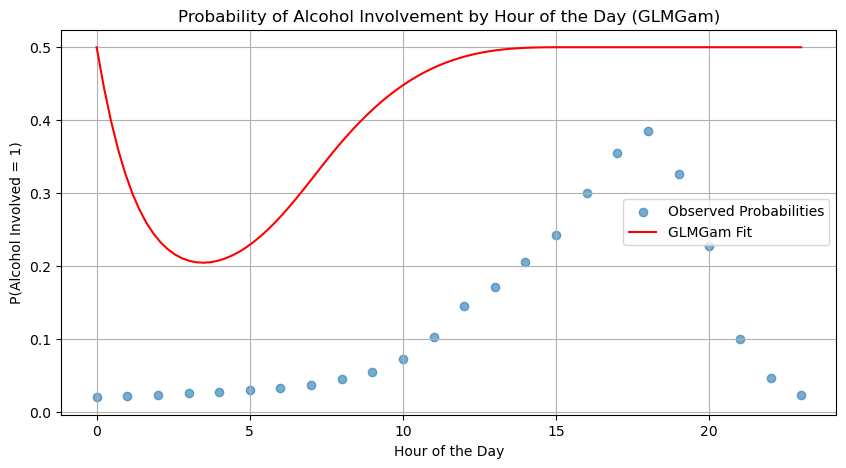

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

# Group by hour and compute probability of alcohol involvement
hourly_data = dfc.groupby("hour")["alcohol_involved"].agg(["mean", "count"])
hourly_data = hourly_data.reset_index()
hourly_data["adj_hour"] = [16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# Prepare data
X = [16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
y = hourly_data["mean"].values  # Probability of alcohol involvement

# Define B-Spline basis functions for smoothing
splines = BSplines(X, df=[6], degree=[3])  # df=6 controls the flexibility of the spline

# Fit the GAM model with binomial (logistic) link function
gam = GLMGam(y, smoother=splines, family=sm.families.Binomial()).fit()

# Generate new data for prediction
hour_range = np.linspace(0, 23, 100).reshape(-1, 1)

# Apply the same spline transformation to hour_range
hour_range_spline = splines.transform(hour_range)

# Predict probabilities
predictions = gam.predict(exog_smooth=hour_range_spline)

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(hourly_data["adj_hour"], hourly_data["mean"], label="Observed Probabilities", alpha=0.6)
plt.plot(hour_range, predictions, color="red", label="GLMGam Fit")
plt.xlabel("Hour of the Day")
plt.ylabel("P(Alcohol Involved = 1)")
plt.title("Probability of Alcohol Involvement by Hour of the Day (GLMGam)")
plt.legend()
plt.grid()
plt.show()

In [41]:
dfc.query("hour == 2")["alcohol_involved"].mean()

UndefinedVariableError: name 'hour' is not defined